# Analyzing Beacon Data 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import urllib
import os

In [2]:
dir_path = 'ftp://data.munroelab.ca/pub/iceberg/beacon/'
dir_contents = urllib.request.urlopen(dir_path).read().splitlines()
filenames = [str(listing.split()[-1])[2:-1] for listing in dir_contents]
csv_filenames = [filename for filename in filenames if filename.startswith('0')
                and filename.endswith('csv')]
kml_filenames = [filename for filename in filenames if filename.startswith('0')
                and filename.endswith('kml')]
metadata_filename = filenames[-1]

In [3]:
beacon_metadata = pd.read_csv(dir_path + metadata_filename)

In [4]:
beacon_metadata

,BeaconID,IMEI,ArgosID,WMO,DataOwner,DataSharingRestrictions,Contact,BeaconType,Manufacturer,Transmitter,...,RelatedBeaconIDs,AdditionalDatasets,Project,Photos_Y_N,NumberPhotos,PhotoCredits,PhotoRestrictions,PhotoComments,PhotoNames,Comments
0,204980,300000000000000,NaN,NaN,"Water and Ice Research Laboratory, Carleton Un...",1,Derek Mueller,FT-2000,Solara,Iridium,...,"906790, 2790480, 2792490","sail/keel mapping with laser and multibeam, CT...",Statoil/ArcticNet Research Cruise 2015,Y,7,"Derek Mueller, Anna Crawford",4,NaN,"204980_2015_approaching the saddle berg 1.JPG,...",Beacon deployed during ArcticNet/Statoil/WIRL ...
1,505190,300000000000000,NaN,NaN,"Water and Ice Research Laboratory, Carleton Un...",1,Derek Mueller,FT-2000,Solara,Iridium,...,"907780, 2791420","photogrammetry, laser scanning",Statoil/ArcticNet Research Cruise 2015,Y,10,"Derek Mueller, Anna Crawford",4,NaN,"505190_2015_Approaching tabular berg.JPG, 5051...",Beacon deployed during ArcticNet/Statoil/WIRL ...
2,906790,300000000000000,NaN,NaN,"Water and Ice Research Laboratory, Carleton Un...",1,Derek Mueller,FT-2000,Solara,Iridium,...,"204980, 2790480, 2792490","sail/keel mapping with laser and multibeam, CT...",Statoil/ArcticNet Research Cruise 2015,Y,See 204980,See 204980,4,NaN,see 204980,Beacon deployed during ArcticNet/Statoil/WIRL ...
3,907780,300000000000000,NaN,NaN,"Water and Ice Research Laboratory, Carleton Un...",1,Derek Mueller,FT-2000,Solara,Iridium,...,"505190, 2791420","photogrammetry, laser scanning",Statoil/ArcticNet Research Cruise 2015,Y,See 505190,See 505190,4,NaN,see 505190,Beacon deployed during ArcticNet/Statoil/WIRL ...


In [5]:
def get_df(data_dir_path, data_fname):
    
    df = pd.read_csv(data_dir_path + data_fname)
    df.loc[:, 'DataDate_UTC'] = pd.to_datetime(df['DataDate_UTC'])
    
    return df

In [6]:
df = get_df(dir_path, csv_filenames[1])

In [7]:
df.head()

,BeaconID,BeaconType,DataDate_UTC,TransmissionDate_UTC,Latitude,Longitude,VBatt,AT,ST,BP,Heading,Speed,LocAccuracy,MessageIndex,Satellites,GPSdelay,SNR,TTFF
0,50519,Solara,2015-04-23 18:48:37,NaN,49.22403,-51.25820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50519,Solara,2015-04-23 18:49:07,NaN,49.22401,-51.25817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50519,Solara,2015-04-23 18:49:34,NaN,49.22400,-51.25809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50519,Solara,2015-04-23 18:49:59,NaN,49.22403,-51.25789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50519,Solara,2015-04-23 18:50:26,NaN,49.22399,-51.25789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
def get_day_idxs(dft, day_inc = 5):

    day_idxs = []
    day_js = []
    day_j = 0
    
    for i in range(len(df)):
        day = (dft[i] - dft[0]).days
        if day == day_j:
            day_idxs.append(i)
            day_js.append(day_j)
            day_j += day_inc
    
    return day_idxs, day_js

In [9]:
def plot_drift_track(df, data_fname):
    
    fig = plt.figure()

    x, y = df['Longitude'], df['Latitude']
    
    plt.scatter(x, y, s=2)
    
    t = df['DataDate_UTC']
    day_idxs, day_js = get_day_idxs(t)
    
    for i, day_idx in enumerate(day_idxs):
    
        plt.text(x[day_idx], y[day_idx], str(day_js[i]), fontsize=16, )
    
    plt.title(f'Drift Track from {data_fname}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    return fig

# Animation

# Simulation

In [10]:
from icedef import constants, iceberg, metocean, drift, tools

In [11]:
def get_iceberg_velocity_from_dataframe(df, start_index, end_index):
    
    dt = (df.DataDate_UTC[end_index] - df.DataDate_UTC[start_index]).total_seconds()  
    dlat = df.Latitude[end_index] - df.Latitude[start_index]
    dlon = df.Longitude[end_index] - df.Longitude[start_index]
    
    mid_lat = (df.Latitude[end_index] + df.Latitude[start_index]) / 2
    
    dy = tools.dlat_to_dy(dlat)
    dx = tools.dlon_to_dx(dlon, mid_lat)
    
    vx = dx/dt
    vy = dy/dt
    
    v = (vx, vy)
    
    return v

In [12]:
csv_filenames

['0204980_2015.csv',
 '0505190_2015.csv',
 '0906790_2015.csv',
 '0907780_2015.csv']

In [13]:
def drift_wrapper(berg_inits, meto, time_info, **kwargs):
    
    start_time, start_latitude, start_longitude, start_velocity = berg_inits
    
    berg = iceberg.quickstart(start_time, (start_latitude, start_longitude), 
                              velocity=start_velocity)
            
    time_step, end_time = time_info
    dt = time_step.item().total_seconds()

    berg_constants = {
    'form_drag_coefficient_in_air': kwargs.pop('Ca', berg.FORM_DRAG_COEFFICIENT_IN_AIR),
    'form_drag_coefficient_in_water': kwargs.pop('Cw', berg.FORM_DRAG_COEFFICIENT_IN_WATER),
    'skin_drag_coefficient_in_air': berg.SKIN_DRAG_COEFFICIENT_IN_AIR,
    'skin_drag_coefficient_in_water': berg.SKIN_DRAG_COEFFICIENT_IN_WATER,
    'sail_area': berg.geometry.sail_area,
    'keel_area': berg.geometry.keel_area,
    'top_area': berg.geometry.waterline_length**2,
    'bottom_area': 0,
    'mass': berg.geometry.mass,
    'latitude': berg.latitude
    }
        
    point = (berg.time, berg.latitude, berg.longitude)
    
    current_velocity = (meto.interpolate(point, meto.ocean.eastward_current_velocities),
                        meto.interpolate(point, meto.ocean.northward_current_velocities))

    wind_velocity = (meto.interpolate(point, meto.atmosphere.eastward_wind_velocities),
                     meto.interpolate(point, meto.atmosphere.northward_wind_velocities))

    while berg.time < end_time:
        
        berg.update_history()

        ax, ay = drift.newtonian_drift((berg.eastward_velocity, berg.northward_velocity), 
                                 current_velocity, wind_velocity, 
                                 berg_constants)

        berg.time += time_step
        berg.eastward_velocity += ax * dt
        berg.northward_velocity += ay * dt
        berg.latitude += tools.dy_to_dlat(berg.northward_velocity * dt)
        berg.longitude += tools.dx_to_dlon(berg.eastward_velocity * dt, berg.latitude)

        point = (berg.time, berg.latitude, berg.longitude)

        current_velocity = (meto.interpolate(point, meto.ocean.eastward_current_velocities),
                            meto.interpolate(point, meto.ocean.northward_current_velocities))

        wind_velocity = (meto.interpolate(point, meto.atmosphere.eastward_wind_velocities),
                         meto.interpolate(point, meto.atmosphere.northward_wind_velocities))

        berg_constants['latitude'] = berg.latitude
            
    return berg

In [14]:
df = get_df(dir_path, csv_filenames[2])

start_index = 1100
end_index = 1120

start_time = np.datetime64(df.DataDate_UTC[start_index])
start_latitude = df.Latitude[start_index]
start_longitude = df.Longitude[start_index]
start_velocity = get_iceberg_velocity_from_dataframe(df, start_index, start_index + 10)

end_time = np.datetime64(df.DataDate_UTC[end_index])

ref_berg = iceberg.quickstart(start_time, (start_latitude, start_longitude))

for i in range(end_index - start_index + 2):

    ref_berg.time = np.datetime64(df.DataDate_UTC[start_index + i])
    ref_berg.latitude = df.Latitude[start_index + i]
    ref_berg.longitude = df.Longitude[start_index + i]
    ref_berg.update_history()

time_step = np.timedelta64(360, 's')
#dt = time_step.item().total_seconds()
#nt = int((end_time - start_time) / time_step)

time_info = (time_step, end_time)

berg = iceberg.quickstart(start_time, (start_latitude, start_longitude), velocity=start_velocity)

meto = metocean.Metocean((start_time, end_time))

In [15]:
berg2 = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                      meto, time_info, Ca=3, Cw=0.1)
berg3 = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                      meto, time_info, Ca=0.1, Cw=5)

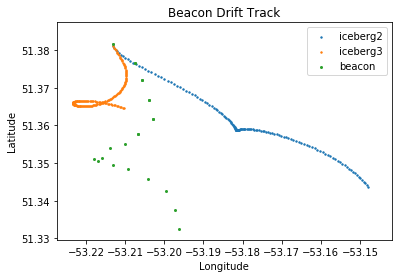

In [16]:
plt.scatter(berg2.history['longitude'], berg2.history['latitude'], s=2, label='iceberg2')
plt.scatter(berg3.history['longitude'], berg3.history['latitude'], s=2, label='iceberg3')

plt.scatter(ref_berg.history['longitude'], ref_berg.history['latitude'], s=4, label='beacon')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Beacon Drift Track')
plt.show()

# Optimization

In [17]:
from scipy.optimize import minimize

In [18]:
def optimization_wrapper(form_drag_coefficients, ref_berg, berg_inits, meto, time_info):
    
    Ca, Cw = form_drag_coefficients
    
    berg = drift_wrapper(berg_inits, meto, time_info, Ca=Ca, Cw=Cw)
    
    try:
        mse = tools.compute_mse((berg.longitude, berg.latitude, berg.time),
                           (ref_berg.history['longitude'], ref_berg.history['latitude'], ref_berg.history['time']),
                           ref_berg.history['time'][0] - np.timedelta64(1,'D'))
    except:
        print(berg2.time)
        raise
    
    return mse
    

In [61]:
callback_mses = []
callback_Cas = []
callback_Cws = []

def callback(x):
    
    result = optimization_wrapper(x, ref_berg, (start_time, start_latitude, start_longitude, start_velocity), 
                                     meto, time_info)
    callback_mses.append(result)
    callback_Cas.append(x[0])
    callback_Cws.append(x[1])

In [76]:
# WARNING: make sure to re-init berg before running minimization

berg = iceberg.quickstart(start_time, (start_latitude, start_longitude), velocity=start_velocity)

optimization_result = minimize(optimization_wrapper, x0=(1, 1), bounds=((0.5, 15), (0.5, 15)), 
                               args=(ref_berg, (start_time, start_latitude, start_longitude, start_velocity), 
                                     meto, time_info), callback=callback)
optimization_result

      fun: 0.026560046409399265
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8.28816182e-06, -4.65634475e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 57
      nit: 15
   status: 0
  success: True
        x: array([ 2.05533429, 12.42601852])

In [77]:
from mpl_toolkits.mplot3d import Axes3D

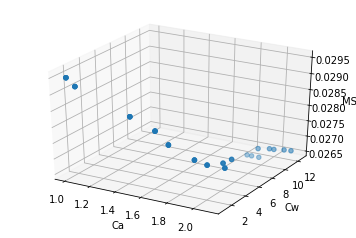

In [78]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(np.array(callback_Cas), np.array(callback_Cws), np.array(callback_mses))

ax.set_xlabel('Ca')
ax.set_ylabel('Cw')
ax.set_zlabel('MSE')

plt.show()

In [79]:
# WARNING: make sure to re-init berg before running minimization

berg = iceberg.quickstart(start_time, (start_latitude, start_longitude), velocity=start_velocity)

optimization_result = minimize(optimization_wrapper, x0=(1, 1), bounds=((0, 15), (0, 15)), 
                               args=(ref_berg, (start_time, start_latitude, start_longitude, start_velocity), 
                                     meto, time_info), callback=callback)
optimization_result

      fun: 0.026560046409399265
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8.28816182e-06, -4.65634475e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 57
      nit: 15
   status: 0
  success: True
        x: array([ 2.05533429, 12.42601852])